In [1]:
import pandas as pd
import tensorflow as tf
from underthesea import sent_tokenize
from underthesea import word_tokenize
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
files = [
    ('vn_news_223_tdlfr.csv', None),
    ("vnexpress2024.csv", 0),
    ("fakenews2401.csv", 1),
    ("fakenews2601.csv", 1),
    ("lacai1.csv", 1),
    ("lacai2.csv", 1),
    ("lacai3.csv", 1)
]

# Initialize an empty DataFrame
df = pd.read_csv('vn_news_223_tdlfr.csv')[['text', 'label']]

# Loop through files and append them
for file, label in files:
    df1 = pd.read_csv(file)[['text', 'label']]
    if label is not None:
        df1['label'] = label
    df = pd.concat([df, df1], ignore_index=True)

X = df.drop('label', axis=1)
y = df['label']
content = X['text']


In [3]:
from gensim.models import Word2Vec
pretrained_model = Word2Vec.load(r'pretrained_word2vec.model')

In [4]:
stopwords = ["bị", "bởi", "cả", "các", "cái", "cần", "càng", "chỉ", "chiếc", "cho", "chứ", "chưa", "chuyện", "có", "có_thể", "cứ", "của", "cùng", "cũng", "đã", "đang", "đây", "để", "đến_nỗi", "đều", "điều", "do", "đó", "được", "dưới", "gì", "khi", "không", "là", "lại", "lên", "lúc", "mà", "mỗi", "một_cách", "này", "nên", "nếu", "ngay", "nhiều", "như", "nhưng", "những", "nơi", "nữa", "phải", "qua", "ra", "rằng", "rằng", "rất", "rất", "rồi", "sau", "sẽ", "so", "sự", "tại", "theo", "thì", "trên", "trước", "từ", "từng", "và", "vẫn", "vào", "vậy", "vì", "việc", "với", "vừa"]
sent = set()
## Sentence tokenization
for i in range(0, len(content)):
    sentence = sent_tokenize(content[i])
    for s in sentence:
        sent.add(s)
sent = list(sent)

for i in range(0, len(sent)):
    sent[i] = re.sub('[\W]', ' ', sent[i].lower())
    tokens = []
    for t in word_tokenize(sent[i]):
        t = t.replace(" ", "_")
        if t not in stopwords:
            tokens.append(t)
    sent[i] = tokens


In [5]:
pretrained_model.build_vocab(sent, update=True)  # Cập nhật từ vựng
pretrained_model.train(
    sent,                                          # Dữ liệu mới
    total_examples=pretrained_model.corpus_count,  # Số câu
    epochs=pretrained_model.epochs  # Số vòng lặp
)

(16311048, 17341360)

In [6]:
pretrained_model.wv.most_similar("nữ_sinh")

[('nam_sinh', 0.6045082807540894),
 ('nữ_sinh_học', 0.4889271557331085),
 ('em', 0.4794144630432129),
 ('gái_nghi', 0.4768286943435669),
 ('bá_sữa', 0.47642457485198975),
 ('đăng_khải', 0.4758461117744446),
 ('y_thường', 0.47512057423591614),
 ('thí_sính', 0.47042664885520935),
 ('cháu', 0.46254533529281616),
 ('trần_quốc_k', 0.4625362157821655)]

In [7]:
for i in range(len(content)):
    tokenized_word = [word for word in word_tokenize(content[i].lower()) if word not in stopwords]
    for j in range(len(tokenized_word)):
        tokenized_word[j] = tokenized_word[j].replace(" ", "_")
    content[i] = " ".join(tokenized_word)


In [8]:
# Khởi tạo Tokenizer và tạo từ điển
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',
    lower=True,
    split=' ')
tokenizer.fit_on_texts(content)

# Chuyển văn bản thành chuỗi số
sequences = tokenizer.texts_to_sequences(content)

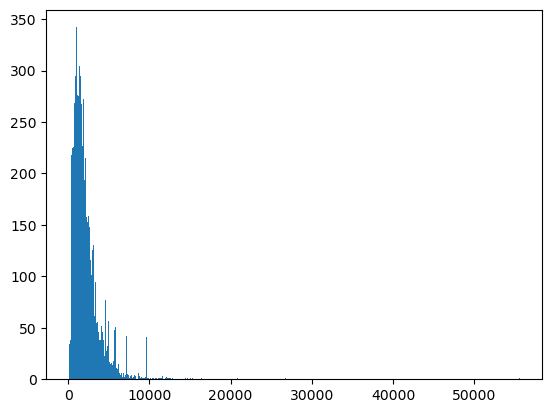

In [9]:
import matplotlib.pyplot as plt
plt.hist([len(c) for c in content], bins=500)
plt.show()

In [10]:
import numpy as np
nos = np.array([len(c) for c in content])
len(nos[nos  < 2500])

4769

In [11]:
### Find max news length
max_length = 2500

max_length

padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

In [12]:
embedding_dim = pretrained_model.vector_size  # Kích thước vector từ trong Word2Vec
vocab_size = len(tokenizer.word_index) + 1  # Số lượng từ trong từ điển (+1 để cho từ padding)

# Khởi tạo ma trận nhúng
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Lấp đầy ma trận nhúng
for word, i in tokenizer.word_index.items():
    if word in pretrained_model.wv:
        embedding_matrix[i] = pretrained_model.wv[word]  # Gán vector nhúng của từ vào
    else:
        embedding_matrix[i] = np.random.uniform(-0.01, 0.01, embedding_dim)  # Vector ngẫu nhiên cho từ không tìm thấy

print("Kích thước ma trận nhúng:", embedding_matrix.shape)


Kích thước ma trận nhúng: (40670, 300)


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Khởi tạo mô hình
model = Sequential()

# Embedding Layer
model.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_length,
    trainable=False  # Giữ nguyên embedding để bảo toàn kiến thức ngữ nghĩa
))

# Bidirectional LSTM
model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)))

# Attention Mechanism (Global MaxPooling)
model.add(GlobalMaxPooling1D())

# Dense Layers với Dropout
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output Layer (cho phân loại nhị phân)
model.add(Dense(1, activation='sigmoid'))  # Chỉ còn 1 neuron đầu ra

# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=3e-4),
    loss='binary_crossentropy',  # Thay bằng binary_crossentropy
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2500, 300)         12201000  
                                                                 
 bidirectional (Bidirectiona  (None, 2500, 256)        439296    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

Epoch 1/5
46/46 [==============================] - 2189s 47s/step - loss: 0.9154 - accuracy: 0.7401 - val_loss: 0.2286 - val_accuracy: 0.9306
Epoch 2/5
46/46 [==============================] - 1954s 42s/step - loss: 0.3402 - accuracy: 0.9446 - val_loss: 0.1500 - val_accuracy: 0.9533
Epoch 3/5
46/46 [==============================] - 2215s 48s/step - loss: 0.2095 - accuracy: 0.9635 - val_loss: 0.0975 - val_accuracy: 0.9722
Epoch 4/5
46/46 [==============================] - 1928s 42s/step - loss: 0.1500 - accuracy: 0.9746 - val_loss: 0.1768 - val_accuracy: 0.9386
Epoch 5/5
46/46 [==============================] - 1923s 42s/step - loss: 0.1361 - accuracy: 0.9740 - val_loss: 0.0893 - val_accuracy: 0.9730
Loss on test set: 0.0893
Accuracy on test set: 0.9730


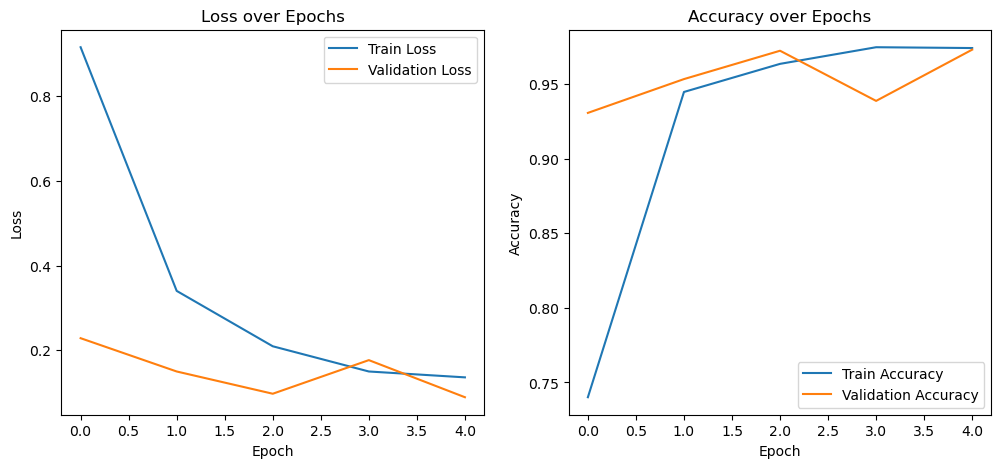

In [14]:
# Chia tập dữ liệu
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, y, test_size=0.2, random_state=42
)

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

# Huấn luyện mô hình
history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_test, y_test), 
    epochs=5,  
    batch_size=120,  
    callbacks=[early_stopping], 
    verbose=1,
    class_weight={0: 1.0, 1: 5669 / 1172}  # Điều chỉnh trọng số lớp nếu cần
)

# Đánh giá mô hình
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Loss on test set: {loss:.4f}")
print(f"Accuracy on test set: {accuracy:.4f}")

# Vẽ biểu đồ loss và accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

43/43 [==============================] - 196s 5s/step
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.99      0.97      0.98      1135
     Class 1       0.89      0.97      0.92       234

    accuracy                           0.97      1369
   macro avg       0.94      0.97      0.95      1369
weighted avg       0.97      0.97      0.97      1369



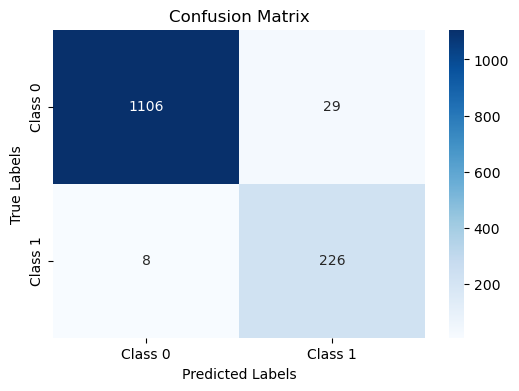

In [15]:
# Đánh giá mô hình với ma trận nhầm lẫn
y_pred_prob = model.predict(X_test)  # Dự đoán xác suất
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Chuyển thành nhãn 0 hoặc 1

# In classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Class 0", "Class 1"]))

# Vẽ confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
